In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *

## Boundary

In [2]:
nf = 8
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

boundary_points = pd.DataFrame(Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

## Interior

In [10]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = 289

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='MQ')
X0 = uh.X_0()

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

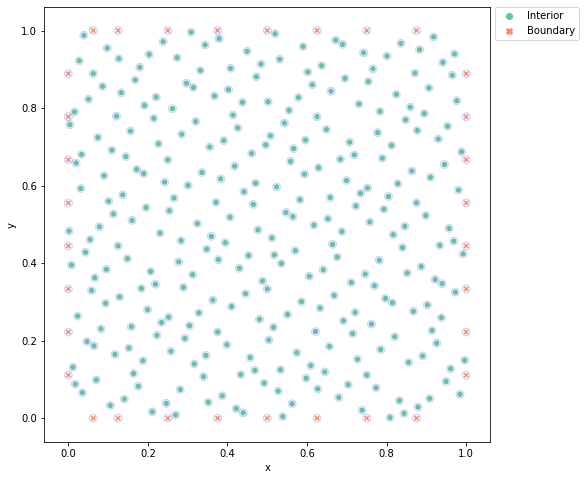

In [11]:
points = pd.concat([interior_points, boundary_points])

stable = stabillity(Mb, npnts)
qx = stable.qX()

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation',
                style='Collocation', palette='Set2')
for hk in points[['x', 'y']].values:
    c = plt.Circle(hk, qx, fill=False, alpha=0.2, color='b')
    ax.add_patch(c)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);

In [12]:
qx

0.00995686214723135

In [6]:
points

,x,y,Collocation
0,0.50000,0.333333,Interior
1,0.25000,0.666667,Interior
2,0.75000,0.111111,Interior
3,0.12500,0.444444,Interior
4,0.62500,0.777778,Interior
5,0.37500,0.222222,Interior
6,0.87500,0.555556,Interior
7,0.06250,0.888889,Interior
8,0.56250,0.037037,Interior
9,0.31250,0.370370,Interior


In [ ]:
#uh.epsilon = 5.956
stable = stabillity(Mb, npnts)
cond, det = stable.cond_num(uh.ACaps())
print('Condition number: {:,.0f} \nDeterminant: {:,.15f}'.format(cond, det))

In [ ]:
t0, te = 0, 1
N = 10
X0 = uh.X_0()
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [ ]:
exp_RK.solve()

In [ ]:
exp_RK.timegrid

In [ ]:
def plot_solution(M, Mi, i):
    n = int(M.shape[0]/Mi.shape[0])
    df_i = pd.DataFrame()
    for _ in range(n):
        df_i = pd.concat([df_i, pd.DataFrame(Mi, columns=['x', 'y'])])
    df_i = df_i.reset_index().rename(columns={'index': 'i'})
    df = pd.DataFrame(M, columns=['u', 'v', 't'])
    df = pd.concat([df_i, df], axis=1)
    dff = df.loc[df['i'] == i]
    plt.figure(figsize=(8, 8))
    sns.lineplot(x='t', y='v', data=dff)
    return df

def u(Mi, norm_x, t, alpha=1.):
    return Mi/((t+alpha) + (t+alpha)**2 * np.exp(norm_x**2/(4*(alpha +t))))

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ex = u(uh.Mi, norm_x, 0.1)
np.mean(abs(ex - exp_RK.solution[1])/ex)

## Exact solution

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
n_X = np.linalg.norm(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), axis=1).reshape(-1,1)
X, Y = np.meshgrid(X, Y)
t=0.05
V = Y/((1+t) + (1+t)*np.exp(n_X/(4*(1+t))))

# Plot the surface.
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
L, H = np.pi*np.mgrid[-1:1:1000j, -1:1:1000j]
T = np.cos(L)*np.cos(2*H)
H = np.cos(L) + H
fig, ax = plt.subplots()
surf = plt.contourf(L, H, T, cmap="hot")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
L, H = np.pi*np.mgrid[-1:1:10j, -1:1:10j]
L

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')